# What am i doing here?

I would love for pretrained neural networks to learn continuously while they are facing real world data to ensure their robustness and make them more intelligent.

Before I started studying AI i actually thought this was the case. I mean sure. ANNs train with labelled data to then label unknown data. So, further training would require us to handlabel a lot of these real life data points. Wasn't this the reason why we trained the ANN in the first place? So we don't have to do that? This is the most exhausting part of facing a new task with ML. Also this kind of screams overfitting haha

How about, we let an ensemble of networks make the prediction and if 1 out of the 3 or 5 networks is out of line we train it using the label the other networks picked. No hand labelling. No overfitting. 

:-)

#Greetings!
This is where I will lay down the framework for my bachelor's thesis. I hope this works out. It is especially difficult for me to find a start. To pick up the work. But. I will now. How about a step-by-step plan?

- How do I need to prepare the data?

- What are 5 architectures that are simple and work well on MNIST?

- What does the post-training look like?

- How do I abstract the data to simulate real world data process change?

How about some more general questions that I could focus on in my writing. To further discuss and compare my work to what others accomplished before me. To make sense of my work and put it into context. Set some measurements and results i want to achieve with my approach.

- What other "keep my model robust and accurate during application" methods are out their?

- What are their advantages and disadvantages?

- What do they aim for?

- Where does my concept finds its place in the realm of ensemble networks?

- Where are weaknesses in my implementation of the idea?

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float64')

## 1. DATA

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
def plot(x):
    x = x.numpy()
    if x.ndim == 2:
        x = x[0]
    fig, ax = plt.subplots(1)
    x = x.reshape((28,28))
    ax.imshow(x, cmap='gray')
    ax.axis("off")

def getmax(x):
    x = list(x.numpy())
    prob = np.max(x)
    pred = x.index(prob)
    return prob, pred

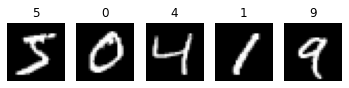

In [4]:
# Check it out
fig, ax = plt.subplots(1,5)
for i in range(5):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

In [5]:
# Normalize the data
train_images = train_images / 255
test_images = test_images / 255

In [6]:
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
# the mapping function maps each  element to the dataset to the value defined by the lambda function
# reshapes each tensor to vector
train_dataset_images = train_dataset_images.map(lambda img : tf.reshape(img, (-1,)))


train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10))

# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.shuffle(buffer_size=128)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images = test_dataset_images.map(lambda img : tf.reshape(img, (-1,)))

test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10))

test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.shuffle(buffer_size=128)

In [7]:
# Splitting it for posttraining
split_num = int(40000/128)
train_dataset_pre = train_dataset.take(split_num)
train_dataset_post = train_dataset.skip(split_num)
train_dataset_post

<SkipDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>

In [8]:
num1 = 0
num2 = 1

# Create binary ds
mask = np.logical_or(train_labels == num1, train_labels == num2)
train_images_bi = train_images[mask]
train_labels_bi = train_labels[mask]

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images_bi)
# the mapping function maps each  element to the dataset to the value defined by the lambda function
# reshapes each tensor to vector
train_dataset_images = train_dataset_images.map(lambda img : tf.reshape(img, (-1,)))


train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels_bi)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 1))

# zip together input and labels
train_ds_bi = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_ds_bi = train_ds_bi.batch(128)
train_ds_bi = train_ds_bi.shuffle(buffer_size=128)

# create 2nd mask
mask = np.logical_or(test_labels == num1, test_labels == num2)
test_images_bi = test_images[mask]
test_labels_bi = test_labels[mask]

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images_bi)
test_dataset_images = test_dataset_images.map(lambda img : tf.reshape(img, (-1,)))

test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels_bi)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 1))

test_ds_bi = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))
test_ds_bi = test_ds_bi.batch(128)
test_ds_bi = test_ds_bi.shuffle(buffer_size=128)

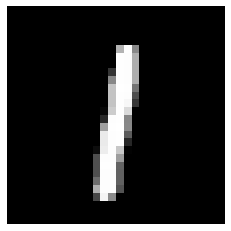

In [9]:
for x,y in test_ds_bi:
    plot(x)
    break

In [10]:
# Splitting it for posttraining
split_num = int(40000/128)
train_ds_bi_pre = train_ds_bi.take(split_num)
train_ds_bi_post = train_ds_bi.skip(split_num)
train_ds_bi_pre

<TakeDataset shapes: ((None, 784), (None, 1)), types: (tf.float64, tf.float32)>

# 2. MODELS
Well, we gotta figure out which architectures work well for our dataset. At best, we find them already trained for exactly our dataset on the internet and download them. Noice.

In [11]:
from tensorflow.keras.layers import Dense

In [12]:
class NN(tf.keras.Model):

    def __init__(self, nodes=[256, 256], num_classes=10):
        super(NN, self).__init__()
        self.num_classes = num_classes
        self.model = [tf.keras.layers.Dense(x, activation=tf.keras.activations.sigmoid) for x in nodes]
        self.model.append(tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax))


    def call(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [13]:
class CNN(tf.keras.Model):
    
    def __init__(self, config=[(32, 3)], num_classes=10):
        super(CNN, self).__init__()
        self.num_classes = num_classes
        self.model = [(tf.keras.layers.Conv2D(filters=x,
                                              kernel_size=y,
                                              padding='same',
                                              activation=tf.keras.activations.relu),
                       tf.keras.layers.MaxPool2D(pool_size=(2,2))) for (x,y) in config]
        # Flatten the model tuple list
        self.model = list(sum(self.model, ()))
        self.out = [tf.keras.layers.GlobalAveragePooling2D(),
                       tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
                       tf.keras.layers.Dense(self.num_classes, activation=tf.keras.activations.softmax)]

    def call(self, x):
        if len(x.shape) == 1:
            x = tf.reshape(x, (1, 28, 28, 1))
        else:
            x = tf.reshape(x, (x.shape[0], 28, 28, 1))
        for layer in self.model:
            x = layer(x)
        for layer in self.out:
            x = layer(x)
        return x

In [14]:
"""num_classes = 2
# Deep model
model1 = NN([256], num_classes)
# Broad Model
model2 = NN([128], num_classes)
# Small Model
model3 = NN([64, 64], num_classes)
# pyramid
model4 = NN([32, 32, 32], num_classes)
# BIGGEST
model5 = NN([16, 16, 16, 16], num_classes)"""

'num_classes = 2\n# Deep model\nmodel1 = NN([256], num_classes)\n# Broad Model\nmodel2 = NN([128], num_classes)\n# Small Model\nmodel3 = NN([64, 64], num_classes)\n# pyramid\nmodel4 = NN([32, 32, 32], num_classes)\n# BIGGEST\nmodel5 = NN([16, 16, 16, 16], num_classes)'

# 3. PRE TRAINING
This is where we train our models to a certain accuracy or download pretrained models. For training we need to input our datapoints to every network simultaneously and declare the prediciton by vote.

For the post-training the following intel must be collected if one network makes a different prediction than the others: 
- The datapoint
- The label given by the najority of the networks
- The index of the presumably wrong model

So a triplet. With each post-training iteration we got a dataset for every model and they train individually on these errors and not on the presumably correct predictions to avoid overfitting.

In [55]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        print(prediction)
        print(target)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [16]:
def pretraining(model, num_epochs=10, bi=False):
    tf.keras.backend.clear_session()

    ### Hyperparameters
    learning_rate = 0.001
    running_average_factor = 0.95

    # Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
    cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
    # Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []
    test_accuracies = []

    # Get datasets
    if bi==False:
        global train_dataset_pre
        global test_dataset
    else:
        global train_ds_bi
        global test_ds_bi
        train_dataset_pre = train_ds_bi_pre
        test_dataset = test_ds_bi

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset_pre, cross_entropy_loss)
    train_losses.append(train_loss)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print('Epoch: __ ' + str(epoch))

        train_dataset_pre = train_dataset_pre.shuffle(buffer_size=128)
        test_dataset = test_dataset.shuffle(buffer_size=128)

        #training (and checking in with training)
        running_average = 0
        for (input,target) in train_dataset_pre:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)

        #testing
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"LOSS {test_loss} ::: ACC {test_accuracy}")

In [28]:
num_classes = 10
# Deep model
model1 = NN([128, 128], num_classes)
# Broad Model
model2 = NN([512], num_classes)
# Small Model
model3 = NN([256, 256], num_classes)
# cnn
model4 = CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = CNN([(32, 3), (64, 5)], num_classes)

In [19]:
"""
pretraining(model1, 1, bi=False)
pretraining(model2, 1, bi=False)
pretraining(model3, 1, bi=False)
pretraining(model4, 1, bi=False)
pretraining(model5, 1, bi=False)
model1.save_weights('code/models/NN128128')
model2.save_weights('code/models/NN512')
model3.save_weights('code/models/NN256256')
model4.save_weights('code/models/CNN3264128')
model5.save_weights('code/models/CNN3264')
"""

Epoch: __ 0
LOSS 0.3688032327196266 ::: ACC 0.9025909810126582


In [30]:
model1.load_weights('code/models/NN128128')
model2.load_weights('code/models/NN512')
model3.load_weights('code/models/NN256256')
model4.load_weights('code/models/CNN3264128')
model5.load_weights('code/models/CNN3264')

# 4. POST TRAINING

Post training should work as followed:

While applying the ensemble network in a real world environment, we collect the new datapoints where the prediction was not unanimous and label them with our prediction and the index of the one network that predicted something else.

We split the dataset by the last variable, after we collected enough datapoints and then train each network on their own to ensure robustness for the ensemble network while facing changing real life data. 

In [31]:
from collections import Counter

In [49]:
class Ensemble(tf.keras.Model):

    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = models
        self.__data = None
        self.__missed_data = None
        self.num_classes = models[0].num_classes

    def call(self, x):
        """The ensemble is either predicting unanimous, 
        or one model is off and the datapoint is collected
         for this models posttraining.
         In any other case the ensemble returns [0.]*10 == No prediction.
         Needs to be handlabeled.
         """
        
        predictions = []
        for model in self.models:
            result = list(model(x).numpy())
            predictions.append(np.argmax(result, axis=1))
        
        # Transpose to let every index be the predictions for 1 datapoint
        x = x.numpy()
        predictions = np.transpose(predictions)
        output = np.zeros((len(x), self.num_classes))
        for idx, prediction in enumerate(predictions):
            
            # All nets give same predictions
            if len(set(prediction)) == 1:
                output[idx] = tf.one_hot(prediction[0], self.num_classes)
                continue

            # Nets give 2 different answers
            if len(set(prediction)) == 2:
                c = Counter(prediction)
                pred1 = list(set(prediction))[0]
                pred2 = list(set(prediction))[1]
                pred1count = c[pred1]
                pred2count = c[pred2]

                if pred1count == 1:
                    self.__collect_data(x, label=pred2, wrong_model=list(prediction).index(pred1))
                    output[idx] = tf.one_hot(list(set(prediction))[1], self.num_classes)
                    continue

                elif pred2count == 1:
                    self.__collect_data(x, label=pred1, wrong_model=list(prediction).index(pred2))
                    output[idx] = tf.one_hot(list(set(prediction))[0], self.num_classes)
                    continue
    
            # Unsure. Save for later review.
            self.__collect_miss(x[idx])
            output[idx] = [0.] * self.num_classes # := Unsure
            
        return tf.convert_to_tensor(output)

    def __collect_data(self, x, label, wrong_model):
        """Add the current datapoint to self.data 
        with the index of the model that needs to be trained on that datapoint
        and the label predicted by the other networks.
        """
        img = tf.data.Dataset.from_tensor_slices(x)
        label_onehot = tf.data.Dataset.from_tensor_slices([label]).map(lambda x: tf.one_hot(x, self.num_classes))
        wrong_model = tf.data.Dataset.from_tensor_slices([wrong_model])
        datapoint = tf.data.Dataset.zip((img, label_onehot, wrong_model))
        if self.__data == None:
            self.__data = datapoint
        else:
            self.__data = self.__data.concatenate(datapoint)

    def __collect_miss(self, x):
        """Collect a datapoint which could not be determined.
        Review by hand later.
        """
        ds = tf.data.Dataset.from_tensor_slices([x])
        if self.__missed_data == None:
            self.__missed_data = ds
        else:
            self.__missed_data = self.__missed_data.concatenate(ds)
            
    def get_data(self):
        return self.__data#.map(lambda x,y,z: (tf.squeeze(x),tf.squeeze(y),z))

    def get_missed_data(self):
        return self.__missed_data#.map(lambda x: tf.squeeze(x))
                                            
    def reset_data(self):
        """Data should be reset after each posttraining."""
        self.__data = None
        self.__missed_data = None

In [50]:
ensemble = Ensemble([model1, model2, model3, model4, model5])

#### Some helper functions

#### Check how the nets individually predict and getting the datacollecting right

Actual Label:  (1.0, 9)
Model 1: (0.8029706659401826, 9)
Model 1: (0.9603093853196627, 9)
Model 1: (0.9356488615043704, 9)
Model 1: (0.9792022384897237, 9)
Model 1: (0.362127376709741, 9)
Ensemble: (1.0, 9)


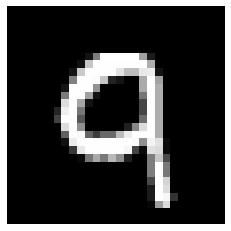

In [34]:
for x,y in test_dataset.unbatch():
    plot(x)
    print("Actual Label: ", getmax(y))
    x = np.expand_dims(x, axis=0)
    for model in ensemble.models:
        print(f"Model 1: {getmax(model(x)[0])}")
    print(f"Ensemble: {getmax(ensemble(x)[0])}")
    break

### Getting started with posttraining framework

For the posttraining we have to split our dataset by the last variable in the datapoint and then train each model in the ensemble network individually.


In [51]:
# Collecting data 
ensemble.reset_data()
for (input, label) in train_dataset_post.take(1):
    pred = ensemble(input)

In [36]:
len(ensemble.get_missed_data())

5

In [37]:
len(ensemble.get_data())

21

In [38]:
for x,y,z in ensemble.get_data().take(1):
    print(x,y,z)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [39]:
ensemble.get_missed_data()

<ConcatenateDataset shapes: (784,), types: tf.float64>

In [40]:
test_dataset

<ShuffleDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>

In [34]:
for (x,y) in test_dataset.take(1):
    print(x,y)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 784), dtype=float64) tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 10), dtype=float32)


In [35]:
"""# model counter
dist = np.zeros(5)
for (x,y,z) in ensemble.data:
    dist[z] += 1

# Show distribution of ensemble.data
fig, ax = plt.subplots()
ax.bar(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], dist)
plt.show()
"""

"# model counter\ndist = np.zeros(5)\nfor (x,y,z) in ensemble.data:\n    dist[z] += 1\n\n# Show distribution of ensemble.data\nfig, ax = plt.subplots()\nax.bar(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], dist)\nplt.show()\n"

In [54]:
_, accuracy = test(ensemble, test_dataset, tf.keras.losses.CategoricalCrossentropy())
accuracy

0.8275316455696202

In [56]:
def posttraining(ensemble, num_epochs=10):
    tf.keras.backend.clear_session()

    ### Hyperparameters
    learning_rate = 0.0005
    running_average_factor = 0.95

    # Initialize the loss: categorical cross entropy.
    cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []
    test_accuracies = []

    # Get datasets
    train_ds_new = ensemble.get_data().batch(1)
    #train_ds_new = train_ds_new.batch(128)
    global test_dataset

    # testing once before we begin
    test_loss, test_accuracy = test(ensemble, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print('Epoch: __ ' + str(epoch))

        #train_ds_new = train_ds_new.shuffle(buffer_size=128)
        #test_dataset = test_dataset.shuffle(buffer_size=128)

        # training (and checking in with training)
        running_average = 0
        for (input,target,model_index) in train_ds_new:
            train_loss = train_step(ensemble.models[int(model_index)], input, target, cross_entropy_loss, optimizer)
            print(train_loss)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)

        # testing
        test_loss, test_accuracy = test(ensemble, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"LOSS {test_loss} ::: ACC {test_accuracy}")

In [ ]:
posttraining(ensemble, 1)

In [ ]:
"""
Epoch: __ 0
tf.Tensor(
[[0.00264005 0.00050683 0.03025515 0.00633547 0.10507429 0.00153617
  0.00188732 0.37871936 0.00310558 0.46993977]], shape=(1, 10), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 10), dtype=float32)
tf.Tensor(0.7551507353782654, shape=(), dtype=float64)
tf.Tensor(
[[8.68028860e-03 2.17086081e-08 6.06123716e-01 3.29074103e-02
  7.51862222e-03 2.17260663e-01 3.01549415e-03 2.41740493e-02
  7.87857775e-03 9.24411567e-02]], shape=(1, 10), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor(1.5266574621200562, shape=(), dtype=float64)
...
tf.Tensor(
[[3.29172335e-03 1.95627526e-04 1.51238852e-01 1.10512080e-01
  1.27141905e-03 2.37514641e-02 4.15754478e-03 3.68533133e-02
  2.53630502e-01 4.15097474e-01]], shape=(1, 10), dtype=float64)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor(3.300809860229492, shape=(), dtype=float64)
LOSS nan ::: ACC 0.09760680379746836
"""

# Plotting theoretical approach

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,24))
x = np.linspace(0,1)
postrain3 = 3 * x**2 * (1-x)
negtrain3 = 3 * (1-x)**2 * x
postrain5 = 5 * x**4 * (1-x)
negtrain3 = 3 * (1-x)**2 * x
negtrain5 = 5 * (1-x)**4 * x
miss5 = 10* ((1-x)**3*x**2 + x**3*(1-x)**2)
allhit5 = x**5
allmiss5 = (1-x)**5
plt.suptitle("Theoretical Analysis of the method")
ax[0].set_title("Probability distribution of positive ensemble training")
ax[1].set_xlabel("Accuracy of the networks")
ax[0].set_xlabel("Accuracy of the networks")
ax[1].set_ylabel("Probabilty")
ax[0].set_ylabel("Probabilty of positive training")
ax[2].set_xlabel("Accuracy")
ax[2].set_ylabel("Probabilty")
ax[0].plot(x, postrain3)
ax[0].plot(x, postrain5)
ax[0].plot(x, negtrain3)
ax[0].plot(x, negtrain5)
ax[1].set_title("Probability distributions of all possible outcomes")
ax[1].plot(x, miss5)
ax[1].plot(x, allhit5)
ax[1].plot(x, allmiss5)
ax[1].plot(x, postrain5)
ax[1].plot(x, negtrain5)
ax[1].plot(x, miss5+allhit5+allmiss5+negtrain5+postrain5)
ax[2].plot(x, allhit5+postrain5)
ax[2].plot(x, allmiss5+negtrain5)
ax[2].plot(x, miss5)
ax[2].set_title("Predictions plus training")

#plot dotted line at 0.7
ax[0].axvline(0.7, linestyle='--')

# Plot the red markes
for point in [0.3, 0.7]:
    value3 = 3*point**2*(1-point)
    value5 = 5*point**4*(1-point)
    ax[0].plot(0.7, value3, 'ro')
    ax[0].plot(0.7, value5, 'bo')
    ax[0].annotate(str(value3),xy=(0.7,value3))
    ax[0].annotate(str(value5),xy=(0.7,value5))
    
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].legend(['3 Networks Positive Training', '5 Networks Positive Training', '3 Networks Negative Training', '5 Networks Negative Training', 'x = 70%'])
ax[1].legend(['No Prediction', 'All right', 'All wrong', 'Positive Training', 'Negative Training', 'Sum'])
ax[2].legend(['Correct Prediction', 'Wrong Prediction', 'No Prediction'])
plt.show()

So, this sums up the basic idea.

Now a couple of questions arise: 
- Should we only posttrain later layers?

  - Sounds like a good idea.
- Should we split the dataset and adjust epochs etc. for every model?
  - Probably.
- How accurate should the pretrained models be?
  - Christoph knows how to test this
- How should we handle the case were the ensemble is unsure?
  - Collect the data too to get it handlabeled and then train all models with it later.
- How can we simulate changing "real world data"?
  - (Doesnt work. Subclasses not correlated enough) Take cifar100. Take out a subclass for every class. Train models on classes, not subclasses. Build ensemble. Slowly add pictures of missing subclasses.
- And still, which architectures do we use?

0kay broski

was denn deine forschungsfrage?

Wie akkurat müssen klassifizierer sein um sich gegenseitig effektiv trainieren zu können?

- wohin willst du hiermit?
  - Ich möchte herausfinden wie Continuous Training in ensemble networks funktioniert und es mit anderen techniken vergleichen

- was sind die wichtigen grundlagen die erklärt werden müssen?
 - Ensemble Networks, Feed Forward Networks, CNNs, Continuous Training

- 

